In [1]:
# Imports
import polars as pl
import xgboost as xgb
import numpy as np
import optuna
import math
import statistics as stat
import numbers

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from datetime import datetime

import matplotlib.pyplot as plt


In [11]:
df = pl.read_csv(r"I_66E_to_Glebe.csv", ignore_errors = True).drop("Record_Type","State_Code","F_System","Station_Id","Travel_Dir","Travel_Lane","Restrictions")

# df = df.filter(isinstance(df["Hour_Volume"], numbers.Number))


# df = df.filter(pl.col("Junction") == 1) # Take only the first junction
# date = pl.to_datetime(df[["Year_Record", "Month_Record", "Day_Record"]])
# df = df.with_columns(name = "Date", offset = 0, date)

dates = []
for i in range(len(df)):
    row = df.row(i)
    dates.append(datetime(row[1] + 2000, row[2], row[3]))

df = pl.concat(
    [
        df,
        pl.DataFrame({"DateTime": dates}),
    ],
    how = "horizontal",
)

df = df.with_row_count(name = "index", offset = 0) # add time index column

print(df)

row 1 (1, 11, 1, 1, 7, 1, 1097)
slot 0
1
slot 2
1
slot 3
1
shape: (94_959, 9)
┌───────┬───────┬───────────┬────────────┬───┬───────────┬─────────────┬─────────────┬─────────────┐
│ index ┆ Index ┆ Year_Reco ┆ Month_Reco ┆ … ┆ Day_of_We ┆ Hour_Record ┆ Hour_Volume ┆ DateTime    │
│ ---   ┆ ---   ┆ rd        ┆ rd         ┆   ┆ ek        ┆ ---         ┆ ---         ┆ ---         │
│ u32   ┆ i64   ┆ ---       ┆ ---        ┆   ┆ ---       ┆ i64         ┆ i64         ┆ datetime[μs │
│       ┆       ┆ i64       ┆ i64        ┆   ┆ i64       ┆             ┆             ┆ ]           │
╞═══════╪═══════╪═══════════╪════════════╪═══╪═══════════╪═════════════╪═════════════╪═════════════╡
│ 0     ┆ 0     ┆ 11        ┆ 1          ┆ … ┆ 7         ┆ 0           ┆ 799         ┆ 2011-01-01  │
│       ┆       ┆           ┆            ┆   ┆           ┆             ┆             ┆ 00:00:00    │
│ 1     ┆ 1     ┆ 11        ┆ 1          ┆ … ┆ 7         ┆ 1           ┆ 1097        ┆ 2011-01-01  │
│       ┆    

In [12]:
# Split Data

df_train = df.filter(pl.col("Year_Record") < 22)
df_valid = df.filter(pl.col("Year_Record") >= 22)

print(df_train.head())
print(df_valid.head())

shape: (5, 9)
┌───────┬───────┬───────────┬────────────┬───┬───────────┬─────────────┬─────────────┬─────────────┐
│ index ┆ Index ┆ Year_Reco ┆ Month_Reco ┆ … ┆ Day_of_We ┆ Hour_Record ┆ Hour_Volume ┆ DateTime    │
│ ---   ┆ ---   ┆ rd        ┆ rd         ┆   ┆ ek        ┆ ---         ┆ ---         ┆ ---         │
│ u32   ┆ i64   ┆ ---       ┆ ---        ┆   ┆ ---       ┆ i64         ┆ i64         ┆ datetime[μs │
│       ┆       ┆ i64       ┆ i64        ┆   ┆ i64       ┆             ┆             ┆ ]           │
╞═══════╪═══════╪═══════════╪════════════╪═══╪═══════════╪═════════════╪═════════════╪═════════════╡
│ 0     ┆ 0     ┆ 11        ┆ 1          ┆ … ┆ 7         ┆ 0           ┆ 799         ┆ 2011-01-01  │
│       ┆       ┆           ┆            ┆   ┆           ┆             ┆             ┆ 00:00:00    │
│ 1     ┆ 1     ┆ 11        ┆ 1          ┆ … ┆ 7         ┆ 1           ┆ 1097        ┆ 2011-01-01  │
│       ┆       ┆           ┆            ┆   ┆           ┆             ┆     

In [13]:
# Suppress optuna log messages
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Optuna objective function
def objective_xgb(trial):
    """
    Optuna objective function. Returns
    the RMSE for an XGBoost model
    
    Assumes the training data are 
    polars data frames
    """
    # Get data for the XGBoost model
    xtrain = df_train.drop(["index", "DateTime",  "Hour_Volume"]).to_numpy()
    xvalid = df_valid.drop(["index", "DateTime",  "Hour_Volume"]).to_numpy()

    ytrain = df_train.get_column("Hour_Volume").to_numpy()
    yvalid = df_valid.get_column("Hour_Volume").to_numpy()
    
    dmat_train = xgb.DMatrix(xtrain, label = ytrain)
    dmat_valid = xgb.DMatrix(xvalid, label = yvalid)
    
    # Suggest hyperparameters for XGBoost
    params = {'objective': 'reg:squarederror',
              'eval_metric': 'rmse',
              'seed': 19970507,
              'eta': trial.suggest_float("eta", 1e-2, 0.25, log = True),
              'max_depth': trial.suggest_int("max_depth", 1, 7),
              'lambda': trial.suggest_float("lambda", 1e-8, 100.0, log = True),
              'alpha': trial.suggest_float("alpha", 1e-8, 100.0, log = True),
             }
    
    # To evaluate training progress (set verbose_eval = True)
    watchlist = [(dmat_train, 'train'), (dmat_valid, 'eval')]
    
    # Train the XGBoost model
    xgb_model = xgb.train(params, 
                          dtrain = dmat_train, 
                          num_boost_round = trial.suggest_int("num_boost_round", 20, 3000),
                          evals = watchlist,
                          verbose_eval = False)
    
    xgb_preds_valid = xgb_model.predict(dmat_valid) 
    
    # Return the RMSE
    return math.sqrt(mean_squared_error(yvalid, xgb_preds_valid))


# Set up and run the Optuna study
study_xgb = optuna.create_study(direction = 'minimize')
study_xgb.optimize(objective_xgb, n_trials = 10)

# Create a table showing the best parameters
xgb_table = {
            "Iterations (num_boost_rounds)": study_xgb.best_params['num_boost_round'],
            'Learning Rate (eta)': round(study_xgb.best_params['eta'], 3),
            'Max Depth (max_depth)': round(study_xgb.best_params['max_depth'], 3),
            'Lambda (lambda)': round(study_xgb.best_params['lambda'], 3),
            'Alpha (alpha)': round(study_xgb.best_params['alpha'], 3)
            }

print(xgb_table)

{'Iterations (num_boost_rounds)': 1820, 'Learning Rate (eta)': 0.114, 'Max Depth (max_depth)': 6, 'Lambda (lambda)': 0.014, 'Alpha (alpha)': 0.571}


In [24]:
# Taking the model with the best hyperparameters and testing it
xtrain = df_train.drop(["index", "DateTime", "Hour_Volume"]).to_numpy()
xvalid = df_valid.drop(["index", "DateTime", "Hour_Volume"]).to_numpy()

ytrain = df_train.get_column("Hour_Volume").to_numpy()
yvalid = df_valid.get_column("Hour_Volume").to_numpy()
    
dmat_train = xgb.DMatrix(xtrain, label = ytrain)
dmat_valid = xgb.DMatrix(xvalid, label = yvalid)

best_params = {'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'seed': 19970507,
                'eta': study_xgb.best_params['eta'],
                'max_depth': study_xgb.best_params['max_depth'],
                'lambda': study_xgb.best_params['lambda'],
                'alpha': study_xgb.best_params['alpha'],
                 }

xgb_model = xgb.train(best_params, 
                      dtrain = dmat_train, 
                      num_boost_round = study_xgb.best_params['num_boost_round'],
                      verbose_eval = False)

xgb_preds_valid = xgb_model.predict(dmat_valid)
xgb_preds_train = xgb_model.predict(dmat_train)

print('----------------------------------------------------------')
print('XGBoost validation set RMSE:', math.sqrt(mean_squared_error(yvalid, xgb_preds_valid)))
print('----------------------------------------------------------')
print('Training set RMSE:', math.sqrt(mean_squared_error(ytrain, xgb_preds_train)))

----------------------------------------------------------
XGBoost validation set RMSE: 353.00024973553366
----------------------------------------------------------
Training set RMSE: 94.46473419929485


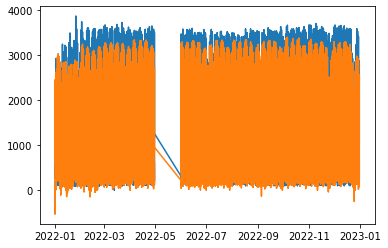

In [15]:
# XGBoost - All of 2022

x = df_valid.get_column('DateTime').to_numpy()

actual = df_valid.get_column("Hour_Volume").to_numpy()
predicted = xgb_preds_valid

plt.plot(x, actual, label = "actual")
plt.plot(x, predicted, label = "predicted")


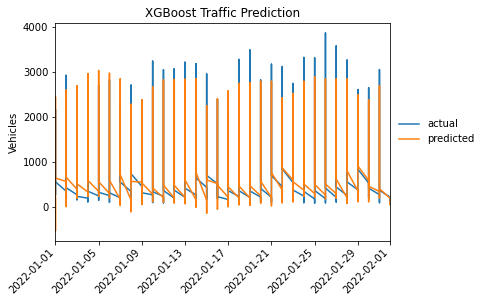

In [16]:
# Jan

pts = 748

x = df_valid.head(pts).get_column('DateTime').to_numpy()
actual = df_valid.head(pts).get_column("Hour_Volume").to_numpy()
predicted = xgb_preds_valid[:pts]

plt.plot(x, actual, label = 'actual')
plt.plot(x, predicted, label = 'predicted')
plt.xticks(rotation = 45, ha = 'right')

plt.ylabel("Vehicles")
plt.xlim(left = min(x), right = max(x))
plt.title("XGBoost Traffic Prediction")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon = False)

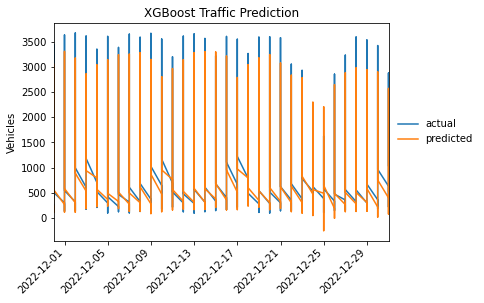

In [17]:
# Dec

pts = 768

x = df_valid.tail(pts).get_column('DateTime').to_numpy()
actual = df_valid.tail(pts).get_column("Hour_Volume").to_numpy()
predicted = xgb_preds_valid[-pts:]

plt.plot(x, actual, label = 'actual')
plt.plot(x, predicted, label = 'predicted')
plt.xticks(rotation = 45, ha = 'right')

plt.ylabel("Vehicles")
plt.xlim(left = min(x), right = max(x))
plt.title("XGBoost Traffic Prediction")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon = False)


In [18]:
# Suppress optuna log messages
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Optuna objective function
def objective_trend_xgb(trial):
    
    # Get data for the trend model
    xtrain_reg = df_train.get_column("index").to_numpy()
    xvalid_reg = df_valid.get_column("index").to_numpy()

    xtrain_reg = xtrain_reg.reshape(-1,1)
    xvalid_reg = xvalid_reg.reshape(-1,1)
    
    ytrain = df_train.get_column("Hour_Volume").to_numpy()
    yvalid = df_valid.get_column("Hour_Volume").to_numpy()
    
    # Train and predict w/ the trend model
    reg_model = LinearRegression().fit(xtrain_reg, ytrain)

    # Predicting
    reg_preds_train = reg_model.predict(xtrain_reg)
    reg_preds_valid = reg_model.predict(xvalid_reg)
    
    # Calculate the residuals
    reg_resids_train = (ytrain - reg_preds_train)
    reg_resids_valid = (yvalid - reg_preds_valid)
    
    # Get the data for the XGB model
    xtrain_xgb = df_train.drop(["index", "DateTime",  "Hour_Volume"]).to_numpy()
    xvalid_xgb = df_valid.drop(["index", "DateTime",  "Hour_Volume"]).to_numpy()
    
    dmat_train = xgb.DMatrix(xtrain_xgb, label = reg_resids_train)
    dmat_valid = xgb.DMatrix(xvalid_xgb, label = reg_resids_valid)
    
    # Suggest hyperparameters
    params = {'objective': 'reg:squarederror',
              'eval_metric': 'rmse',
              'seed': 19970507,
              'eta': trial.suggest_float("eta", 1e-2, 0.25, log = True),
              'max_depth': trial.suggest_int("max_depth", 1, 7),
              'lambda': trial.suggest_float("lambda", 1e-8, 100.0, log = True),
              'alpha': trial.suggest_float("alpha", 1e-8, 100.0, log = True),
             }
    
    # To evaluate training progress (set verbose_eval = True)
    watchlist = [(dmat_train, 'train'), (dmat_valid, 'eval')]
    
    # Train and predict w/ the XGBoost model
    xgb_model = xgb.train(params, 
                          dtrain = dmat_train, 
                          num_boost_round = trial.suggest_int("num_boost_round", 20, 3000),
                          evals = watchlist,
                          verbose_eval = False)
    
    xgb_preds_valid = xgb_model.predict(dmat_valid) 
    
    # Sum the final predictions
    trend_xgb_preds_valid = (reg_preds_valid + xgb_preds_valid)
    
    # Return the RMSE
    return math.sqrt(mean_squared_error(yvalid,  trend_xgb_preds_valid))
    

# Set up and run the Optuna study
study_trend_xgb = optuna.create_study(direction = 'minimize')
study_trend_xgb.optimize(objective_trend_xgb, n_trials = 10)

# Create a table showing the best parameters
trend_xgb_table = [["Parameter", "Optimal Value from Optuna"],
                  ["Iterations (num_boost_rounds)", study_trend_xgb.best_params['num_boost_round']],
                  ['Learning Rate (eta)', round(study_trend_xgb.best_params['eta'], 3)],
                  ['Max Depth (max_depth)', round(study_trend_xgb.best_params['max_depth'], 3)],
                  ['Lambda', round(study_trend_xgb.best_params['lambda'], 3)],
                  ['Alpha', round(study_trend_xgb.best_params['alpha'], 3)]]

print(trend_xgb_table)

[['Parameter', 'Optimal Value from Optuna'], ['Iterations (num_boost_rounds)', 2805], ['Learning Rate (eta)', 0.125], ['Max Depth (max_depth)', 2], ['Lambda', 0.0], ['Alpha', 0.232]]


In [19]:
# Taking the model with the best hyperparameters and testing it w/ TREND

# Get data for the trend model
xtrain_reg = df_train.get_column("index").to_numpy()
xvalid_reg = df_valid.get_column("index").to_numpy()

xtrain_reg = xtrain_reg.reshape(-1,1)
xvalid_reg = xvalid_reg.reshape(-1,1)

print(df_train.columns)

ytrain = df_train.get_column("Hour_Volume").to_numpy()
yvalid = df_valid.get_column("Hour_Volume").to_numpy()
    
# Train and predict w/ the trend model
reg_model = LinearRegression().fit(xtrain_reg, ytrain)

# Predicting
reg_preds_train = reg_model.predict(xtrain_reg)
reg_preds_valid = reg_model.predict(xvalid_reg)
    
# Calculate the residuals
reg_resids_train = (ytrain - reg_preds_train)
reg_resids_valid = (yvalid - reg_preds_valid)
    
# Get the data for the XGB model
xtrain_xgb = df_train.drop(["index", "DateTime",  "Hour_Volume"]).to_numpy()
xvalid_xgb = df_valid.drop(["index", "DateTime",  "Hour_Volume"]).to_numpy()
    
dmat_train = xgb.DMatrix(xtrain_xgb, label = reg_resids_train)
dmat_valid = xgb.DMatrix(xvalid_xgb, label = reg_resids_valid)

best_params = {'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'seed': 19970507,
                'eta': study_trend_xgb.best_params['eta'],
                'max_depth': study_trend_xgb.best_params['max_depth'],
                'lambda': study_trend_xgb.best_params['lambda'],
                'alpha': study_trend_xgb.best_params['alpha'],
                 }

xgb_model = xgb.train(best_params, 
                      dtrain = dmat_train, 
                      num_boost_round = study_trend_xgb.best_params['num_boost_round'],
                      verbose_eval = False)

xgb_preds_valid = xgb_model.predict(dmat_valid)

# Sum the final predictions
trend_xgb_preds_valid = (reg_preds_valid + xgb_preds_valid)

print('----------------------------------------------------------')
print('Trend model + XGBoost validation set RMSE:', math.sqrt(mean_squared_error(yvalid, trend_xgb_preds_valid)))
print('----------------------------------------------------------')

['index', 'Index', 'Year_Record', 'Month_Record', 'Day_Record', 'Day_of_Week', 'Hour_Record', 'Hour_Volume', 'DateTime']
----------------------------------------------------------
Trend model + XGBoost validation set RMSE: 412.9673702288844
----------------------------------------------------------


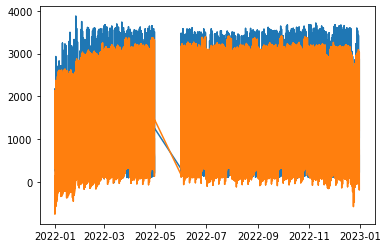

In [20]:
# XGBoost w/ Trend - All of 2022

x = df_valid.get_column('DateTime').to_numpy()

actual = df_valid.get_column("Hour_Volume").to_numpy()
predicted = trend_xgb_preds_valid

plt.plot(x, actual, label = "actual")
plt.plot(x, predicted, label = "predicted")

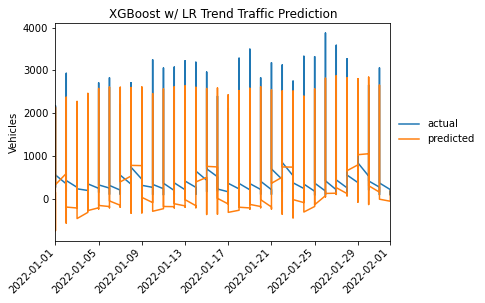

In [21]:
# Jan

pts = 748

x = df_valid.head(pts).get_column('DateTime').to_numpy()
actual = df_valid.head(pts).get_column("Hour_Volume").to_numpy()
predicted = trend_xgb_preds_valid[:pts]

plt.plot(x, actual, label = 'actual')
plt.plot(x, predicted, label = 'predicted')
plt.xticks(rotation = 45, ha = 'right')

plt.ylabel("Vehicles")
plt.xlim(left = min(x), right = max(x))
plt.title("XGBoost w/ LR Trend Traffic Prediction")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon = False)

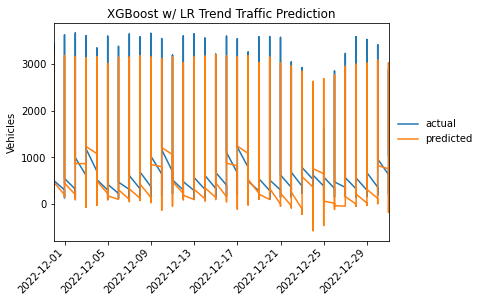

In [22]:
# Dec

pts = 768

x = df_valid.tail(pts).get_column('DateTime').to_numpy()
actual = df_valid.tail(pts).get_column("Hour_Volume").to_numpy()
predicted = trend_xgb_preds_valid[-pts:]

plt.plot(x, actual, label = 'actual')
plt.plot(x, predicted, label = 'predicted')
plt.xticks(rotation = 45, ha = 'right')

plt.ylabel("Vehicles")
plt.xlim(left = min(x), right = max(x))
plt.title("XGBoost w/ LR Trend Traffic Prediction")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon = False)